In [37]:
import os
import pandas as pd
import ptitprince as pt
import matplotlib.pyplot as plt
from metadPy.sdt import rates, dprime, criterion
from metadPy.utils import trials2counts, discreteRatings
from metadPy.hierarchical import hmetad
from scipy.stats import norm
import seaborn as sns
import numpy as np
import pingouin as pg
import arviz as az
from plotting import raincloud

sns.set_context('talk')

Import merged dataframe from behavioral data.

In [38]:
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
merged_df = pd.read_csv(path + '/data/merged.txt')

Filter trial level dataframe, discretize confidence rating and store results in a `metacognition_trials.txt` file.

In [39]:
metacognition_df = pd.DataFrame([])
drop = []
for sub in merged_df.Subject.unique():
    for cond in merged_df.Modality.unique():
        this_df = merged_df[(merged_df.Subject==sub) & (merged_df.Modality==cond)]
        
        # Drop NAs
        this_df = this_df[~this_df.Confidence.isnull()]

        # Discretize ratings
        try:
            new_ratings, out = discreteRatings(this_df.Confidence.to_numpy(), verbose=False)
            this_df.loc[:, 'Confidence'] = new_ratings
            metacognition_df = metacognition_df.append(this_df[['Subject', 'Modality', 'Alpha', 'Estimation', 'Confidence']])

        except ValueError:
            print(f'Dropping subject {sub} due to invalid ratings')
            drop.append(sub)

for sub in drop:
    metacognition_df = metacognition_df[metacognition_df.Subject!=sub]

metacognition_df.columns = ['Subject', 'Condition', 'Stimuli', 'Estimation', 'Confidence']
metacognition_df.loc[:, 'Stimuli'] = metacognition_df['Stimuli'] > 0
metacognition_df.loc[:, 'Estimation'] = metacognition_df['Estimation'] == 'More'
metacognition_df['Accuracy'] = (metacognition_df['Stimuli'] & metacognition_df['Estimation']) | (~metacognition_df['Stimuli'] & ~metacognition_df['Estimation'])

metacognition_df.to_csv(path + '/data/metacognition_trials.txt')

Dropping subject sub_0245 due to invalid ratings


Extract d prime and criterion in `sdt_df` and save response ratings in `responsesRatings_df`.

In [41]:
sdt_df = pd.DataFrame([])
responsesRatings_df = pd.DataFrame([])
for sub in metacognition_df.Subject.unique():
    for cond in metacognition_df.Condition.unique():
        this_df = metacognition_df[(metacognition_df.Subject==sub) & (metacognition_df.Condition==cond)]
        
        nR_S1, nR_S2 = trials2counts(
            data=this_df, stimuli='Stimuli', accuracy='Accuracy',
            confidence='Confidence', nRatings=4)
        
        responsesRatings_df = responsesRatings_df.append(pd.DataFrame({
            'Subject': sub, 'Condition': cond, 'nR_S1': nR_S1, 'nR_S2': nR_S2}))
        
        sdt_df = sdt_df.append(pd.DataFrame({
            'Subject': [sub],
            'Condition': [cond],
            'RespCountS1': nR_S1.sum(),
            'RespCountS2': nR_S2.sum(),
            'Accuracy': this_df.Accuracy.to_numpy().mean() * 100,
            'd': [this_df.dprime(stimuli='Stimuli', responses='Estimation')],
            'c': [this_df.criterion(stimuli='Stimuli', responses='Estimation')]}))

Drop participants whose values for d-prime are outside 1.5 times the interquartile range.

In [5]:
for cond in sdt_df.Condition.unique():
    this_df = sdt_df[(sdt_df.Condition==cond)]

    q1 = this_df['d'].quantile(.25)
    q3 = this_df['d'].quantile(.75)

    for sub in this_df.Subject[this_df['d'] > this_df['d'].quantile(.75) + ((q3 - q1) * 1.5)]:
        print(f'Drop {sub}')
        responsesRatings_df = responsesRatings_df[responsesRatings_df.Subject!=sub]
        sdt_df = sdt_df[sdt_df.Subject!=sub]

    for sub in this_df.Subject[this_df['d'] < this_df['d'].quantile(.25) - ((q3 - q1) * 1.5)]:
        print(f'Drop {sub}')
        responsesRatings_df = responsesRatings_df[responsesRatings_df.Subject!=sub]
        sdt_df = sdt_df[sdt_df.Subject!=sub]

Drop sub_0228


In [6]:
responsesRatings_df.to_csv(path + '/data/responsesRatings.txt')

# d prime and criterion

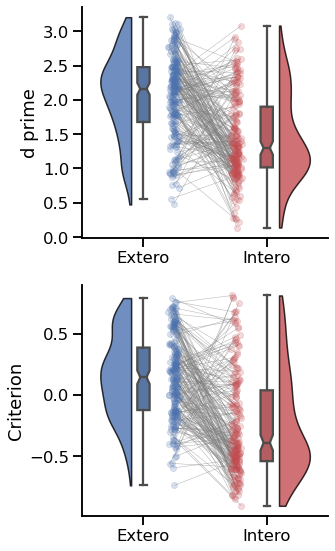

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(5, 8))
for i, metric, title in zip([0, 1], ['d', 'c'], ['d prime', 'Criterion']):
    raincloud(data=sdt_df, x='Condition', y=metric, ax=axs[i])
    axs[i].set_ylabel(title)
    axs[i].set_xlabel('')
    sns.despine()
plt.tight_layout()

In [8]:
pg.pairwise_ttests(data=sdt_df, dv='d', within='Condition', effsize='cohen')

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,Condition,Extero,Intero,True,True,10.072042,210.0,two-sided,1.017600e-19,4.544e+16,1.023084


In [9]:
pg.pairwise_ttests(data=sdt_df, dv='c', within='Condition', effsize='cohen')

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,Condition,Extero,Intero,True,True,11.401531,210.0,two-sided,9.424521e-24,4.17e+20,1.066312


# Raw confidence ratings

In [10]:
rawConfidence_df = pd.DataFrame([])
for sub in metacognition_df.Subject.unique():
    for cond in metacognition_df.Condition.unique():
        for corr in [True, False]:
            this_df = metacognition_df[(metacognition_df.Subject==sub) & (metacognition_df.Condition==cond) & (metacognition_df.Accuracy==corr)]
            new_ratings = this_df.Confidence.to_numpy()
            rawConfidence_df = rawConfidence_df.append(pd.DataFrame({'Subject': sub,
                          'Condition': cond,
                          'Correct': corr,
                          'Ratings': np.arange(1, 5),
                          'Density': np.array([np.count_nonzero(new_ratings == i) for i in range(1, 5)]) / len(new_ratings)}), ignore_index=True)

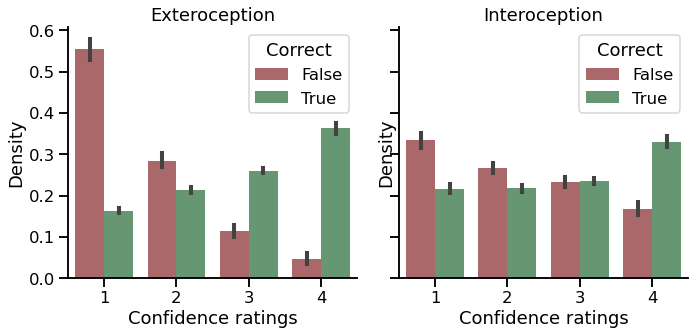

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.barplot(data=rawConfidence_df[rawConfidence_df.Condition=='Extero'], x='Ratings', y='Density', hue='Correct', ax=ax[0], palette=["#b55d60", "#5f9e6e"])
ax[0].set_title('Exteroception')
ax[0].set_xlabel('Confidence ratings')

sns.barplot(data=rawConfidence_df[rawConfidence_df.Condition=='Intero'], x='Ratings', y='Density', hue='Correct', ax=ax[1], palette=["#b55d60", "#5f9e6e"])
ax[1].set_title('Interoception')
ax[1].set_xlabel('Confidence ratings')
plt.tight_layout()
sns.despine()
plt.savefig(path + '/figures/Fig3_confidence.svg', dpi=300)

# Fitting meta-d model using JAGS

## Repeated measures model

In [20]:
samples = pd.read_csv(path + '/data/jagsSamples.txt', sep='\t')

In [28]:
pd.read_csv(path + '/data/jagsStats.txt', sep='\t')

,name,mean
1,"Mratio[1,1]",0.712249
2,"Mratio[2,1]",0.969965
3,"Mratio[3,1]",0.867480
4,"Mratio[4,1]",0.701454
5,"Mratio[5,1]",0.465672
...,...,...
421,"Mratio[210,2]",1.366319
422,"Mratio[211,2]",1.667599
423,lamBd_Condition1,4912.209920
424,muBd_Condition1,-0.256711


In [21]:
stats = pd.read_csv(path + '/data/jagsStats.txt', sep='\t')
stats['Condition'] = 'Intero'
stats.loc[stats.name.str.contains(",2]"), 'Condition'] = 'Extero'
for sub in range(1, 217):
    stats.loc[stats.name.str.contains(str(sub)+','), 'Subject'] = [str(sub)]
stats = stats[stats.name.str.contains('Mratio')]
stats = stats.sort_values('Condition')

Remove outliers (m-ratio > 3)

In [23]:
stats

,name,mean,Condition,Subject
422,"Mratio[211,2]",1.667599,Extero,211
287,"Mratio[76,2]",0.387947,Extero,76
286,"Mratio[75,2]",0.969635,Extero,75
285,"Mratio[74,2]",1.814160,Extero,74
284,"Mratio[73,2]",0.498787,Extero,73
...,...,...,...,...
135,"Mratio[135,1]",0.677625,Intero,135
134,"Mratio[134,1]",1.150550,Intero,134
133,"Mratio[133,1]",0.699647,Intero,133
157,"Mratio[157,1]",0.835006,Intero,157


In [29]:
for sub in stats.Subject[(stats['Condition']=='Intero') & (stats['mean']>3)]:
    #stats = stats[stats.Subject!=sub]
    print(f'Subject {responsesRatings_df.Subject.unique()[int(sub)]} removed')

Subject sub_0224 removed
Subject sub_0197 removed


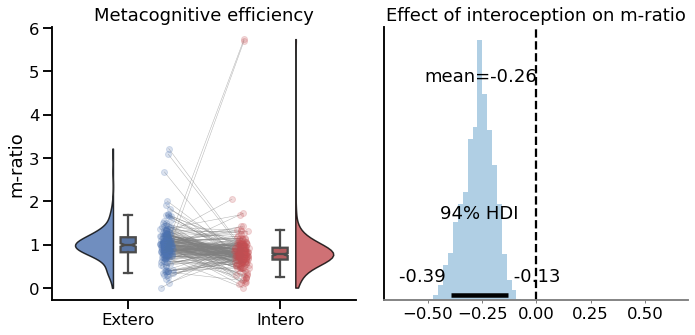

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

raincloud(data=stats, x='Condition', y='mean', ax=axs[0])
axs[0].set_title('Metacognitive efficiency')
axs[0].set_ylabel('m-ratio')
axs[0].set_xlabel('')
sns.despine()

az.plot_posterior(samples.value.to_numpy(), kind='hist', bins=20, ax=axs[1])
axs[1].axvline(x=0, linestyle='--', color='k')
axs[1].set_xlim(-.7, .7)
axs[1].set_title('Effect of interoception on m-ratio')
sns.despine()

plt.tight_layout()
plt.savefig(path + '/figures/Fig3_betas_mratio.svg', dpi=600)

## Subject level fits

Comparison between the Hmeta-d toolbox and metadPy

In [70]:
metadprimeR_df = pd.read_csv(path + '/data/metadprimeHmetad.txt', sep='\t')
metadprimePy_df = pd.read_csv(path + '/data/metadprimeMetadPy.txt')
summary_df = pd.merge(metadprimeR_df, metadprimePy_df, on=['Subject', 'Condition'])

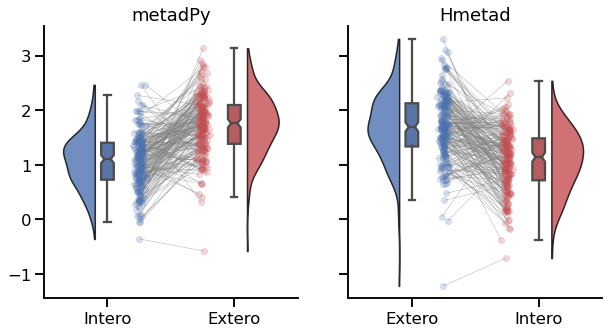

In [87]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
raincloud(data=metadprimePy_df, x='Condition', y='mean', ax=axs[0])
raincloud(data=metadprime_df, x='Condition', y='MetadPrime', ax=axs[1])
axs[0].set_title('metadPy')
axs[1].set_title('Hmetad')
sns.despine()

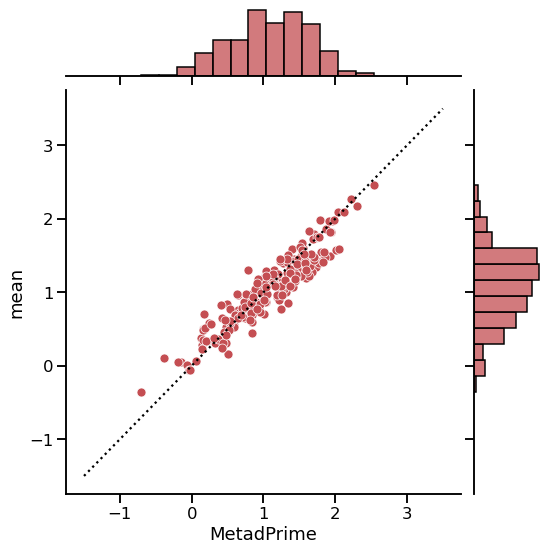

In [80]:
g = sns.jointplot(data=summary_df[summary_df.Condition=='Intero'], x='MetadPrime', y='mean', color='#c44e52', height=8)
lims = [-1.5, 3.5]
g.ax_joint.plot(lims, lims, ':k')

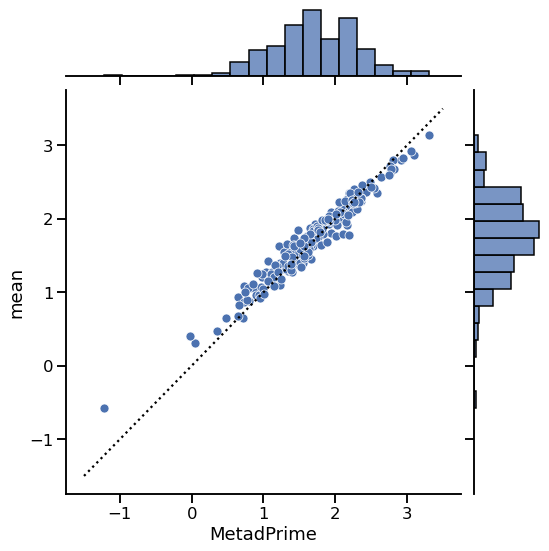

In [81]:
g = sns.jointplot(data=summary_df[summary_df.Condition=='Extero'], x='MetadPrime', y='mean', color='#4c72b0', height=8)
lims = [-1.5, 3.5]
g.ax_joint.plot(lims, lims, ':k')